In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, GRU,
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import Huber
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from keras.callbacks import ReduceLROnPlateau

def quantile_loss(i):
  def loss(y_true, y_pred):
    e = y_true - y_pred
    return tf.reduce_mean(tf.maximum(i * e, (i - 1) * e))
  return loss

X = pd.read_csv("Xtable.csv")
y= X.iloc[:,-1].values
X = X.iloc[:,1:].values

window_size = 20;
step_size = 1;

X_win_all = []
y_win_all = []

for i in range(0,len(X)-window_size,step_size):
  X_win = X[i:i+window_size]
  y_win = y[i+window_size]
  X_win_all.append(X_win)
  y_win_all.append(y_win)

X_win_all=np.array(X_win_all)
y_win_all=np.array(y_win_all)

# Although called val, all variables with val is for testing, because we train a model from scratch in every walk
X_trainval = X_win_all[:]
y_trainval = y_win_all[:]

# Walk forward Validation
shift_win = 11

# In a single walk
n_train = 10
n_valid = 1

pred_train_all = []
pred_val_all = []

true_train_all = []
true_val_all = []

rmse_train_per_walk = []
rmse_val_per_walk = []

train_idx_all = []
val_idx_all = []

hist_tr_loss = []

# Coloumns to be normalized
cols_N = np.concatenate([np.arange(8,37),np.array([38,39,41,42,44,45,47,48,50,51,53,54,56,57,58])])


for start_idx in range(0, len(X_trainval)-n_train-n_valid+1,shift_win):

  X_train = X_trainval[start_idx:start_idx+n_train].copy()
  y_train = y_trainval[start_idx:start_idx+n_train].copy()

  X_val = X_trainval[start_idx+n_train:start_idx+n_train+n_valid]
  y_val = y_trainval[start_idx+n_train:start_idx+n_train+n_valid]

  # Normalization

  normalizer_y = MinMaxScaler(feature_range=(-1, 1))
  normalizer_X = {}

  for k in cols_N:
    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    X_train_k = X_train[:,:,k].reshape(-1,1)
    X_train_scaled = scaler_X.fit_transform(X_train_k)
    X_train[:,:,k] = X_train_scaled.reshape(X_train[:,:,k].shape)
    normalizer_X[k] = scaler_X

  for k in cols_N:
    X_val_k = X_val[:,:,k].reshape(-1,1)
    X_val_scaled = normalizer_X[k].transform(X_val_k)
    X_val[:,:,k] = X_val_scaled.reshape(X_val[:,:,k].shape)

  print("X_train shape:", X_train.shape)
  print("Feature 'open' min/max:", X_train[:, :, k].min(), X_train[:, :, k].max())

  y_train = normalizer_y.fit_transform(y_train.reshape(-1,1))
  y_val = normalizer_y.transform(y_val.reshape(-1,1))

 # Model
  mdl = Sequential([
      Input(shape=[window_size,X_trainval.shape[2]]),
        LSTM(
        units=256,
        input_shape=[window_size,X_train.shape[2]],
        activation='tanh',
      ),
      Dropout(0.2),
      Dense(1)
  ])

  mdl.compile(optimizer=Adam(learning_rate=0.001),loss=quantile_loss(0.5))

  hist = mdl.fit(X_train,
                 y_train,
                 epochs=15,
                 shuffle=False,
                 batch_size=32,
                 callbacks=[ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-6)])

  hist_tr_loss.append(hist.history['loss'])

  train_pred = mdl.predict(X_train)
  val_pred  = mdl.predict(X_val)

  train_pred = train_pred.reshape(-1,1)
  val_pred = val_pred.reshape(-1,1)

  train_pred = normalizer_y.inverse_transform(train_pred)
  val_pred = normalizer_y.inverse_transform(val_pred)

  true_train = normalizer_y.inverse_transform(y_train)
  true_val = normalizer_y.inverse_transform(y_val)

  pred_train_all.append(train_pred)
  pred_val_all.append(val_pred)

  true_train_all.append(true_train)
  true_val_all.append(true_val)

  train_idx = list(range(start_idx + window_size, start_idx + window_size + n_train))
  val_idx = list(range(start_idx + n_train + window_size, start_idx + n_train + window_size + n_valid))

  train_idx_all.append(train_idx)
  val_idx_all.append(val_idx)

  rmse_train_per_walk.append(np.sqrt(mean_squared_error(train_pred,true_train)))
  rmse_val_per_walk.append(np.sqrt(mean_squared_error(val_pred,true_val)))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
X_train shape: (10, 20, 59)
Feature 'open' min/max: -1.0 0.9999999999999982
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.4705 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.2403 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.3079 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1790 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1991 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.2378 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1949 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.1617 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1478 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.1983 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.2195 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2345 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.5006 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.2189 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2164 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.2934 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.2930 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2366 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.1619 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.2003 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1482 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.1903 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2772 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.4063 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.1864 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1890 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.2378 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.1791 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1192 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1975 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1866 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1151 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1244 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2602 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.3144 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2066 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.2630 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.1901 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1901 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1793 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1955 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1786 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.2229 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.1739 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3145 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - loss: 0.3672 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.1896 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - loss: 0.2120 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 0.2622 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.1968 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.1431 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1306 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1739 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.1721 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.1560 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3171 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.1546 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1595 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.2728 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.2040 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.1831 - learning_rate: 5.0000e-04
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1709 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.1268 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1032 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1185 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.1197 - learning_rate: 5.0000e-04
Epoch 12/1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2630 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.3444 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 0.1930 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.2161 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 0.1984 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1795 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1933 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 0.1996 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2075 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.1912 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 0.2039 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3178 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.4414 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.2707 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.2419 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2852 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.2803 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2552 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.2107 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2058 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.2275 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.2204 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2653 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.3968 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.1941 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.2347 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.2784 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2488 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1665 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1465 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.1629 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1979 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.1686 - learning_rate: 5.0000e-04
Epoch 12/15
1/1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2678 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.2104 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.2830 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.2275 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.2192 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1959 - learning_rate: 5.0000e-04
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1634 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.1828 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.1836 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.1717 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.2058 - learning_rate: 2.5000e-04
Epoch 12/15

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3534 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.3073 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1253 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.2619 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1770 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1086 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.2169 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.2579 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1806 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1173 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1326 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3778 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.3034 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.3133 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - loss: 0.2726 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 0.3152 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.3320 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.2712 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.2452 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.2424 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.2471 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.2871 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2698 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.3433 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1871 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1577 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.2378 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1847 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1318 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0643 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0965 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.1267 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0705 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3100 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.1505 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0851 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1707 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1025 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0895 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0847 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0780 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.1014 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0788 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0899 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3394 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.2377 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1410 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1964 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1795 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1547 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1723 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.1923 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1218 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.1167 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0979 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2564 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 0.2018 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 0.1696 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1687 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 0.1233 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1516 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.1099 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.1491 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1366 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1392 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.1436 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2575 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.2890 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1752 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.2208 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2048 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1663 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1615 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1781 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.1886 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1447 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1735 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.3121 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3648 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.1852 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.2126 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2532 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2216 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.1686 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 0.1834 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.1921 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.1845 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.1456 - learning_rate: 2.5000e-04
Epoch 12/15
1/1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3509 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.3096 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.2066 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.2235 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.2436 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2289 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.2307 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.2229 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.2172 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.2055 - learning_rate: 2.5000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.2434 - learning_rate: 2.5000e-04
Epoch 12/15
1/1 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3146 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - loss: 0.4717 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.2928 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.3400 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.3608 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - loss: 0.3444 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 0.3074 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2879 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.2485 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2715 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.2607 - learning_rate: 5.0000e-04
Epoch 12/15
1/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2111 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.4244 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 0.3500 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.2099 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2290 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.2350 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.2256 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.2172 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.1826 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.1648 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.1648 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2968 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.1585 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.1185 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 0.0553 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 0.0977 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 0.0903 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 0.0532 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 0.0864 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.1003 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0884 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 0.0677 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3045 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1880 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0839 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.2157 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.1245 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.2222 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1914 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.1518 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.1068 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0798 - learning_rate: 2.5000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0829 - learning_rate: 2.5000e-04
Epoch 12/15
1/1 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2713 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.2052 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.1245 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1478 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.1124 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0777 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1025 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0820 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0959 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0910 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0717 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2529 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.2188 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2777 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2578 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.2787 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.2950 - learning_rate: 5.0000e-04
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.2770 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.2295 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.1963 - learning_rate: 2.5000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.2241 - learning_rate: 2.5000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.2249 - learning_rate: 2.5000e-04
E

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2961 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.4174 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.2234 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.3077 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.3380 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2989 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2680 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.2057 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.2104 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.2334 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.2124 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2381 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.2130 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1807 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.1637 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 0.1796 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1646 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1632 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - loss: 0.0953 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.1532 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.1681 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1820 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2370 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.4010 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.3687 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 0.2506 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.2657 - learning_rate: 5.0000e-04
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.2557 - learning_rate: 5.0000e-04
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2516 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.2316 - learning_rate: 2.5000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2297 - learning_rate: 2.5000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.2321 - learning_rate: 2.5000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.2073 - learning_rate: 2.5000e-04
Epoch 12/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2381 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2488 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.3985 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.2943 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.2535 - learning_rate: 5.0000e-04
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.2359 - learning_rate: 5.0000e-04
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.2622 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.2327 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2326 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - loss: 0.2464 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.2266 - learning_rate: 5.0000e-04
Epoch 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2104 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.5383 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2478 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.1402 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 0.3243 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.3126 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2009 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1547 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1355 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1093 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1357 - learning_rate: 5.0000e-04
Epoch 12/15

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2486 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1981 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1924 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1929 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.1259 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.1578 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1367 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0737 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0900 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1320 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1064 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2326 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 0.1670 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 0.1858 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.2201 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1249 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.1483 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.1300 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1267 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1628 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1356 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1507 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1678 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.2179 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.2440 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1895 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1518 - learning_rate: 5.0000e-04
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1500 - learning_rate: 5.0000e-04
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1475 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1380 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1202 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0988 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1509 - learning_rate: 5.0000e-04
Epoch 12

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3918 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.2747 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.1867 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2122 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.2245 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1581 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1615 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1865 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1880 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1373 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1678 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2675 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.2175 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.3501 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.2006 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.3085 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.2644 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1928 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1730 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.2099 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.2578 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.2292 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2241 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - loss: 0.2980 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.1585 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.2257 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1872 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1446 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1654 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1709 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.1420 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1605 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1515 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2608 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.3339 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1564 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1862 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.1604 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.1250 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1268 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0895 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1068 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1491 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0798 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2483 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.4258 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.1438 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.2415 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 0.2066 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 0.1109 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.1731 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.1889 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.1628 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.1209 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0857 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2970 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.2774 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1795 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.1998 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1785 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.1736 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.1576 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1714 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1565 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1669 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.1740 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2768 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.3143 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.2047 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.2829 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.2071 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1695 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.2280 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.1462 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1519 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.1377 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1264 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2812 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 0.3390 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1541 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1628 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.1192 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.2210 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.1821 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.1203 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0970 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.1159 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1004 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3868 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.2886 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1763 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.1527 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.1422 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.1247 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1078 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1109 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.1338 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1076 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1043 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2902 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.3607 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2792 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.2707 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 0.2670 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - loss: 0.2353 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.2369 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.2433 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.2191 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.1572 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1666 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2156 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.1802 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.2863 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.2175 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1800 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1498 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1929 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.1354 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1441 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1283 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1344 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3864 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.1873 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.1578 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.2265 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.2710 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.1585 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1393 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.1435 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1323 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.1109 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1507 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.4027 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 0.2977 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.2164 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.1293 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.1870 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 0.1086 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.1386 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.2259 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.1440 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.1281 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.1331 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2042 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.4102 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2996 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2185 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.2096 - learning_rate: 5.0000e-04
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.2261 - learning_rate: 5.0000e-04
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 0.2035 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.1780 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.1862 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.2257 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.2087 - learning_rate: 5.0000e-04
Epoch 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3714 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.2244 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1692 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.1337 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.1267 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 0.1426 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - loss: 0.0846 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0794 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.0908 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0756 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.1135 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3339 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.3244 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.2654 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.2516 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2437 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.2641 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.2568 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.2088 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.2054 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.2010 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.2024 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3500 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.3428 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.2184 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.1614 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.2058 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.1764 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0897 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.1874 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1934 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.1829 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1139 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3943 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.2199 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.1659 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 0.2486 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.1880 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.1302 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.1238 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1809 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1537 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.1982 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1673 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1884 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1138 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.3011 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1436 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.1445 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1630 - learning_rate: 5.0000e-04
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.1469 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.1136 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0789 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.1081 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.1308 - learning_rate: 5.0000e-04
Epoch 12/15
1/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2827 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.4130 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.2520 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.2924 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.2792 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 0.2556 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.2293 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.2182 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.2287 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2406 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.2451 - learning_rate: 5.0000e-04
Epoch 12/15
1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3072 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1274 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1159 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.2497 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.3085 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1860 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0864 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.1154 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0998 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1051 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1100 - learning_rate: 2.5000e-04
Epoch 12/15
1/1 ━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2652 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.3817 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.2405 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.2759 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.2721 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2178 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1699 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2045 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.2191 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 0.1964 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.1590 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3570 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.3893 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.3042 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.3026 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.3000 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.2728 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2685 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.2636 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2668 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.2617 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.2403 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2478 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.3148 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1682 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 0.1568 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1669 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1567 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.1775 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1689 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.1612 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.1800 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1596 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3699 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 0.3293 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1680 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.1891 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.2015 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.1706 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 0.1827 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.1662 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 0.1563 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.1412 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.1419 - learning_rate: 5.0000e-04
Epoch 12/15
1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2537 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1985 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2366 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.1237 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1666 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.2416 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1775 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.1459 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1326 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1314 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.1220 - learning_rate: 2.5000e-04
Epoch 12/15
1/1 ━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3194 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3975 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.3380 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.2160 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.2360 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.2645 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2790 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1788 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.2029 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.1864 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.2074 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2833 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.4258 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.2431 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2017 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.2249 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.2477 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1689 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 0.1316 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1542 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1574 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.1413 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3763 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.2404 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1311 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.2281 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1527 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.1816 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.1068 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1140 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.1387 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.1110 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1180 - learning_rate: 2.5000e-04
Epoch 12/15
1/1 ━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2899 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 0.2316 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 0.1394 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.1732 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - loss: 0.1542 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.1170 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.0955 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.1361 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.1114 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0794 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 0.0889 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2759 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.1817 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1050 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0640 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0792 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1116 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0723 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0971 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.1300 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.1043 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0746 - learning_rate: 2.5000e-04
Epoch 12/15
1/1 ━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3846 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.2805 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.2471 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.1547 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 0.2595 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.2139 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.2117 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.1853 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.1756 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.1660 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.1549 - learning_rate: 2.5000e-04
Epoch 12/15
1/1 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3267 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.3743 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.2504 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.2590 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3530 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2718 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.2543 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.2314 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.2102 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2281 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.2195 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.2831 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.3571 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 0.2685 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.2868 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.2679 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.2645 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.2150 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.2073 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.2420 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.2230 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.2224 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3168 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.2232 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.2455 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 0.2357 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.2229 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1581 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.1201 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.1436 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1619 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.1601 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1359 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3303 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.1723 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 0.0968 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.1739 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 0.1074 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1071 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 0.1072 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0874 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - loss: 0.1056 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - loss: 0.1105 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 0.1046 - learning_rate: 5.0000e-04
Epoch 12/15
1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3012 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.3424 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1967 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.2021 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.2059 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.1382 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.1586 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.1580 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.1690 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1414 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1539 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2931 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.2600 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1793 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.2417 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 0.1135 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.1872 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - loss: 0.2640 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1515 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 0.0950 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.1153 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.1044 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3878 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 0.2287 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1467 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.2076 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1290 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0979 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.1145 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.0730 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1195 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.1299 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0758 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3103 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.2960 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.2339 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.2021 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.1812 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 0.2139 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1667 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1613 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1890 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1558 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.1359 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3315 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.2607 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1987 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2132 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 0.1955 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.1921 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1674 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.2056 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 0.1812 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.1400 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.1495 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2440 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1982 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.1860 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.1996 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.1211 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.1395 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1420 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1033 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.1095 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1163 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0789 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.2653 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1993 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.1597 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.2389 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.2044 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 0.1828 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.1777 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.1955 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.2101 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1799 - learning_rate: 2.5000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1851 - learning_rate: 2.5000e-04
Epoch 12/15
1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3423 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.3521 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.1959 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1126 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1526 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.1319 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.1384 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.1770 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.1595 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.1125 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0947 - learning_rate: 2.5000e-04
Epoch 12/15
1/1 ━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2789 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.3570 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - loss: 0.2710 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.1833 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.1693 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.1769 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.1551 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.1379 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 0.1449 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1335 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.1110 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2152 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.2659 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.1863 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.2439 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.2147 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1393 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1681 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.1581 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.1276 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1540 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.1664 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3216 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.4347 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.3218 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.2436 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.2919 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 0.2804 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 0.2488 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.2393 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.1889 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.2001 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2089 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3325 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1388 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.1507 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.2311 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.2574 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.1868 - learning_rate: 5.0000e-04
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.1896 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1256 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1207 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0942 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0844 - learning_rate: 5.0000e-04
Epoch 12/15

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2929 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.3106 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.1829 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.1981 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.1641 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.1494 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1245 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1657 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1926 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 0.1442 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 0.1278 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2380 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.3657 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.3003 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.2466 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.2558 - learning_rate: 5.0000e-04
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.2274 - learning_rate: 5.0000e-04
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.1689 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.1169 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.1797 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1566 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1613 - learning_rate: 5.0000e-04
Epoch 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2445 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.3065 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.2580 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.2389 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.2327 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.2260 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.2024 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2279 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2269 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.2085 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.1579 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3344 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.3704 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.2066 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.1538 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 0.2400 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - loss: 0.2021 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.2041 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 0.1955 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - loss: 0.1927 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.1795 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1797 - learning_rate: 2.5000e-04
Epoch 12/15
1/1 ━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2133 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.4208 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.2717 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.2450 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.2342 - learning_rate: 5.0000e-04
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2735 - learning_rate: 5.0000e-04
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1931 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.1729 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.1925 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.1894 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.2081 - learning_rate: 5.0000e-04
Epoch 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2746 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.3414 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.2706 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.2367 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.2135 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2191 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.1803 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.1956 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1701 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1633 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1734 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2795 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.3746 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.4330 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.2668 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.2050 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2046 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.2107 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.1921 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1750 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.1694 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1710 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.4266 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2501 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.3629 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.2542 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.1791 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.2381 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2276 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.1915 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.1394 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 0.1409 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 0.1389 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2891 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.2350 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.2966 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2729 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.2379 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2169 - learning_rate: 5.0000e-04
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.2049 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.2083 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.2180 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.1978 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.2089 - learning_rate: 5.0000e-04
Epoch 12/15
1

In [ ]:
pred_err_val = []
true_err_val = []

for i in range(len(pred_val_all)):
  idx = [idx for idx in val_idx_all[i] if idx < len(y)]
  pred_err_val.extend(pred_val_all[i].flatten()[:len(idx)])
  true_err_val.extend(y[idx])

rmse_val_err = np.sqrt(mean_squared_error(pred_err_val,true_err_val))
r2_val_err = r2_score(pred_err_val,true_err_val)
mae_val_err = mean_absolute_error(pred_err_val,true_err_val)
mape_val_err = mean_absolute_percentage_error(pred_err_val,true_err_val)
acc_val_err = (1-mae_val_err/np.mean(true_err_val))*100

pred_err_train = []
true_err_train = []

for i in range(len(pred_train_all)):
  idx = [idx for idx in train_idx_all[i] if idx < len(y)]
  pred_err_train.extend(pred_train_all[i].flatten()[:len(idx)])
  true_err_train.extend(y[idx])

rmse_train_err = np.sqrt(mean_squared_error(pred_err_train,true_err_train))
r2_train_err = r2_score(pred_err_train,true_err_train)
mae_train_err = mean_absolute_error(pred_err_train,true_err_train)
mape_train_err = mean_absolute_percentage_error(pred_err_train,true_err_train)
acc_train_err = (1-mae_train_err/np.mean(true_err_train))*100

print(f"TRAIN RMSE: {rmse_train_err}")
print(f"TRAIN R2: {r2_train_err}")
print(f"TRAIN MAE: {mae_train_err}")
print(f"TRAIN MAPE: {mape_train_err}")
print(f"TRAIN ACC: {acc_train_err}")

print(f"TEST RMSE: {rmse_val_err}")
print(f"TEST R2: {r2_val_err}")
print(f"TEST MAE: {mae_val_err}")
print(f"TEST MAPE: {mape_val_err}")
print(f"TEST ACC: {acc_val_err}")

TRAIN RMSE: 67.98093019703079
TRAIN R2: 0.9995861581057603
TRAIN MAE: 42.666530934979846
TRAIN MAPE: 0.0076621312103121045
TRAIN ACC: 99.24763563542427
TEST RMSE: 142.62194018247172
TEST R2: 0.9981778667470572
TEST MAE: 104.15193810903894
TEST MAPE: 0.018654977463676885
TEST ACC: 98.1753958883439


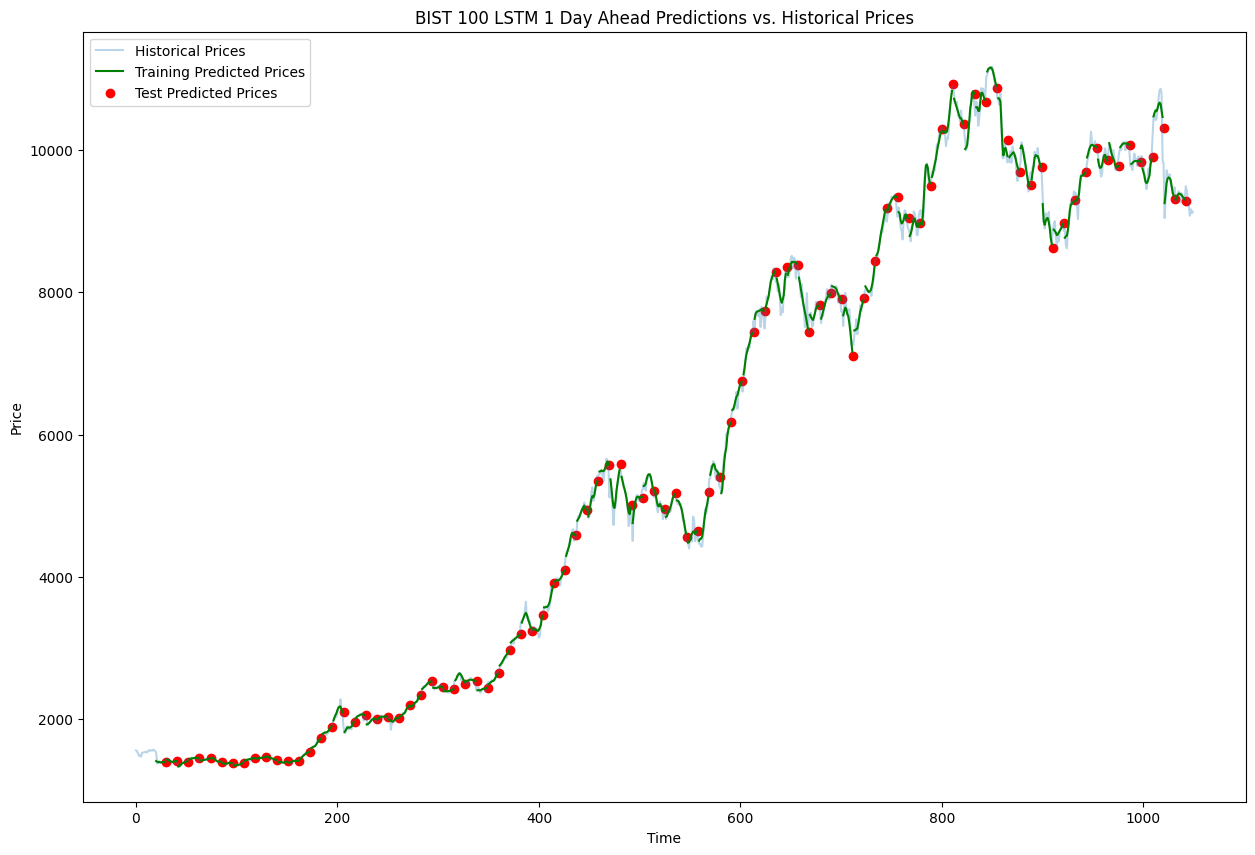

In [ ]:
train_idx = list(range(window_size, window_size + len(train_pred)+1))
val_idx = list(range(window_size + len(train_pred),+ window_size + len(train_pred) + len(val_pred)+1))

plt.figure(figsize=(15,10))

plt.plot(range(len(y)),y, label='Historical Prices', alpha=0.3)

for i in range(len(pred_train_all)):
  if i >= 1:
    plt.plot(train_idx_all[i],pred_train_all[i], color="green")
  else:
    plt.plot(train_idx_all[i],pred_train_all[i], label='Training Predicted Prices', color="green")

for i in range(len(pred_val_all)):
  if i >= 1:
    plt.scatter(val_idx_all[i],pred_val_all[i], color="red")
  else:
    plt.scatter(val_idx_all[i],pred_val_all[i], label='Test Predicted Prices', color="red")


plt.title('BIST 100 LSTM 1 Day Ahead Predictions vs. Historical Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
pred_val_all_flat = np.concatenate([p.flatten() for p in pred_val_all])
true_val_all_flat = np.concatenate([p.flatten() for p in true_val_all])
res = true_val_all_flat - pred_val_all_flat

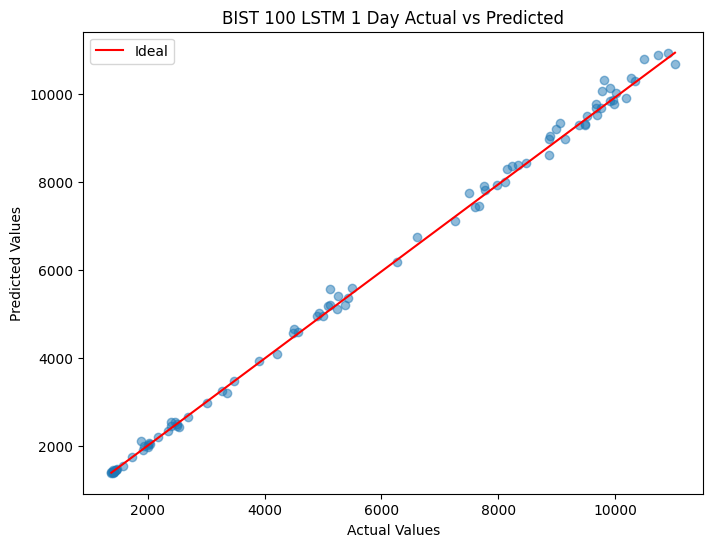

In [ ]:
plt.figure(figsize=(8,6))

plt.scatter(true_val_all_flat, pred_val_all_flat, alpha=0.5)
plt.plot([min(true_val_all_flat),max(true_val_all_flat)],[min(pred_val_all_flat),max(pred_val_all_flat)],"r", label="Ideal")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("BIST 100 LSTM 1 Day Actual vs Predicted")
plt.legend()
plt.show()

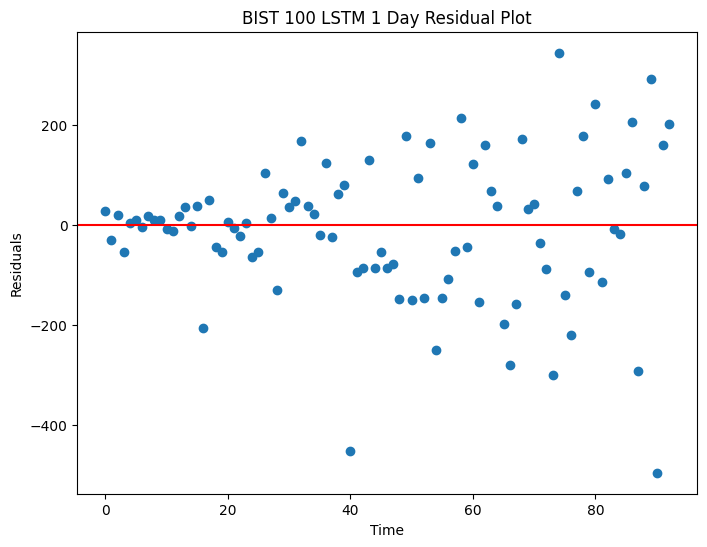

In [ ]:
plt.figure(figsize=(8,6))

plt.scatter(range(len(res)),res)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.title("BIST 100 LSTM 1 Day Residual Plot")
plt.show()


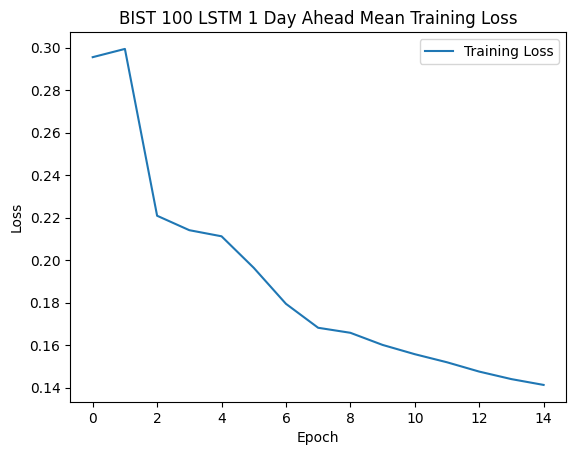

In [ ]:
hist_tr_loss = np.array(hist_tr_loss)

hist_tr_loss_mean = np.mean(hist_tr_loss, axis=0)

plt.plot(hist_tr_loss_mean, label='Training Loss')
plt.title('BIST 100 LSTM 1 Day Ahead Mean Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
